In [ ]:
!git clone -b mittra https://github.com/tirthankar95/CSCI_7000_FinalProject.git
!sudo apt install rar
%cd /content/CSCI_7000_FinalProject/

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed,SimpleRNN,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import re

In [3]:
from HandCraftedEnv.mymixed_env import *

In [5]:
!unrar -r x HandCraftedEnv/novice.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from HandCraftedEnv/novice.rar

Creating    novice                                                    OK
Creating    novice/Novice1.ml                                         OK
Extracting  novice/Novice1.ml/keras_metadata.pb                            0%  OK 
Extracting  novice/Novice1.ml/saved_model.pb                               1%  OK 
Creating    novice/Novice1.ml/variables                               OK
Extracting  novice/Novice1.ml/variables/variables.index                    1%  OK 
Extracting  novice/Novice1.ml/variables/variables.data-00000-of-00001      24%  OK 
Creating    novice/Novice0.ml                                         OK
Extracting  novice/Novice0.ml/keras_metadata.pb                           24%  OK 
Extracting  novice/Novice0.ml/saved_model.pb                              26%  OK 
Creating    novice/Novice0.ml/variables    

In [6]:
N_NOVICE=4
noviceArr=[]
for _ in range(N_NOVICE):
  temp_model=keras.models.load_model(f'novice/Novice{_}.ml')
  noviceArr.append(temp_model)

In [7]:
#Create a mixed env.
mixedGrid=[[0,0,4,0],[1,0,0,0],[0,0,2,0],[0,0,0,0]] 
env3=mixedEnv()
env3.reset(mixedGrid)
env3.printEnv()



0 0 4 0 
1 0 0 0 
0 0 2 0 
0 0 0 0 





In [10]:
def plotProgress(reward_plot,xlabel,ylabel,title):
    plt.plot(reward_plot)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(f'{ylabel}.png')
    plt.show()

def create():
    global num_actions,frameForPrediction
    input=Input(shape=(frameForPrediction,25)) # (4,1,5,5) ~ my grid returns (1,2*visibility+1,2*visibility+1)
    temp=LSTM(units=100,return_sequences=False)(input)
    temp=Dense(units=100, activation='relu')(temp)
    temp=Dense(units=50, activation='relu')(temp)
    temp=Dense(units=10, activation='relu')(temp)
    output=Dense(units=num_actions,activation='linear')(temp)
    model=Model(input,output)
    return model

In [15]:
def trainAgentInEnv(env):
  global model,model_target,loss_function,optimizer,reward_plot,action_history,state_history,state_next_history,rewards_history,noOfUpdates,mixedGrid
  # Configuration paramaters for the whole setup
  seed = 42
  gamma = 0.99  # Discount factor for past rewards
  epsilon = 1.0  # Epsilon greedy parameter
  epsilon_min = 0.1  # Minimum epsilon greedy parameter
  epsilon_max = 1.0  # Maximum epsilon greedy parameter
  epsilon_interval = (
      epsilon_max - epsilon_min
  )  # Rate at which to reduce chance of random action being taken
  batch_size = 128  # Size of batch taken from replay buffer
  max_steps_per_episode = 100
  episode_reward_history=[]

  running_reward = 0
  frame_count = 0
  # Number of frames to take random action and observe output
  epsilon_random_frames = 1000
  # Number of frames for exploration
  epsilon_greedy_frames = 1000.0
  # Maximum replay length
  # Note: The Deepmind paper suggests 1000000 however this causes memory issues
  max_memory_length = 10000
  # Train the model after 4 actions
  update_after_actions = 10
  # How often to update the target network
  update_target_network = 1000
  # Using huber loss for stability
  # We are taking 4 frames in our LSTM
  frame_offset=frameForPrediction-1
  noOfEpisodes=100 #beast 100000

  dummy_state=[[[-1 for i in range(5)] for j in range(5)]] #2*visibility+1=5
  dummy_action=-1
  dummy_reward=-1
  dummy=-1
  # Run this multiple times. (1000)
  state, reward, done, _ = env.reset(mixedGrid)
  for _ in tqdm(range(noOfEpisodes)):  # Run until solved
      state, reward, done, _ = env.reset(mixedGrid)
      episode_reward = 0
      for i in range(frame_offset):
        state_history.append(dummy_state)
        state_next_history.append(dummy_state)
        rewards_history.append(dummy_reward)
        action_history.append(dummy_action)
        done_history.append(dummy)
      for timestep in range(1, max_steps_per_episode):
          # env.render(); Adding this line would show the attempts
          # of the agent in a pop up window.
          frame_count += 1
          # Use epsilon-greedy for exploration
          if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
              # Take random action
              action = np.random.choice(num_actions)
          else:
              # Predict action Q-values
              # From environment state
              state_numpy = np.array(state_history[-frameForPrediction:]).reshape(frameForPrediction,25)
              state_numpy = np.array([state_numpy])
              action_probs = model(state_numpy, training=False)
              # Take best action
              action = np.argmax(action_probs[0])

          # Decay probability of taking random action
          epsilon -= epsilon_interval / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min)

          # Apply the sampled action in our environment
          state_next, reward, done, _ = env.step(action)
          episode_reward += reward

          # Save actions and states in replay buffer
          state_history.append(state)
          state_next_history.append(state_next)
          action_history.append(action)
          done_history.append(done)
          rewards_history.append(reward)
          state = state_next

          # Update every fourth frame and once batch size is over 32
          if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
              # Get indices of samples for replay buffers
              noOfUpdates-=1
              if noOfUpdates==0:
                indices = np.random.choice(range(len(done_history)-frame_offset), size=len(done_history))+frame_offset
                noOfUpdates=1000
              else:
                indices = np.random.choice(range(len(done_history)-frame_offset), size=batch_size)+frame_offset
              # Using list comprehension to sample from replay buffer
              state_sample = np.array([ np.array(state_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              state_next_sample = np.array([ np.array(state_next_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              rewards_sample = [rewards_history[i] for i in indices]
              action_sample = [action_history[i] for i in indices]
              # Build the updated Q-values for the sampled future states
              # Use the target model for stability
              future_rewards = model_target.predict(state_next_sample,verbose=False)
              # Q value = reward + discount factor * expected future reward
              updated_q_values = rewards_sample + gamma * np.max(future_rewards, axis=1)
              updated_q_values = updated_q_values.astype('float32')
              # Create a mask so we only calculate loss on the updated Q-values
              masks = tf.one_hot(action_sample, num_actions)
              with tf.GradientTape() as tape:    
                  q_values = model(state_sample)
                  # Apply the masks to the Q-values to get the Q-value for action taken
                  q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                  loss = loss_function(updated_q_values,q_action)
              # Backpropagation
              grads = tape.gradient(loss, model.trainable_variables)
              optimizer.apply_gradients(zip(grads, model.trainable_variables))
              

          if frame_count % update_target_network == 0:
              # update the the target network with new weights
              model_target.set_weights(model.get_weights())
              # Log details
              template = "running reward: {:.2f} at episode {}, frame count {}"
              print(template.format(running_reward, _, frame_count))

          # Limit the state and reward history
          if len(rewards_history) > max_memory_length:
              del rewards_history[:1]
              del state_history[:1]
              del state_next_history[:1]
              del action_history[:1]
              del done_history[:1]
          if done:
              break
      # Update running reward to check condition for solving
      episode_reward_history.append(episode_reward)
      running_reward = np.mean(episode_reward_history)
      reward_plot.append(episode_reward)
      episode_steps_plot.append(timestep)

 12%|█▏        | 12/100 [00:10<00:58,  1.51it/s]

running reward: -72.75 at episode (2, 4), frame count 1000


 23%|██▎       | 23/100 [00:34<02:34,  2.00s/it]

running reward: -81.83 at episode (3, 2), frame count 2000


 35%|███▌      | 35/100 [00:56<01:57,  1.80s/it]

running reward: -79.23 at episode (5, 4), frame count 3000


 47%|████▋     | 47/100 [01:19<01:24,  1.59s/it]

running reward: -79.34 at episode (2, 4), frame count 4000


 57%|█████▋    | 57/100 [01:47<02:05,  2.93s/it]

running reward: -82.79 at episode (4, 4), frame count 5000


 67%|██████▋   | 67/100 [02:09<01:14,  2.27s/it]

running reward: -85.21 at episode (5, 5), frame count 6000


 78%|███████▊  | 78/100 [02:34<00:48,  2.21s/it]

running reward: -86.81 at episode (5, 5), frame count 7000


 88%|████████▊ | 88/100 [02:58<00:28,  2.37s/it]

running reward: -88.19 at episode (3, 2), frame count 8000


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


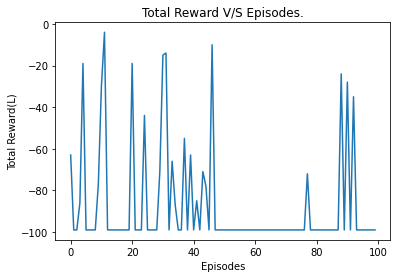

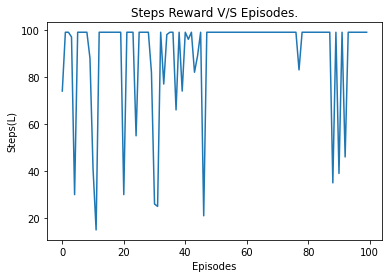

 11%|█         | 11/100 [00:10<01:22,  1.08it/s]

running reward: -78.64 at episode (4, 4), frame count 1000


 22%|██▏       | 22/100 [00:34<03:05,  2.38s/it]

running reward: -88.33 at episode (3, 5), frame count 2000


 32%|███▏      | 32/100 [01:12<04:31,  3.99s/it]

running reward: -89.44 at episode (2, 2), frame count 3000


 42%|████▏     | 42/100 [01:35<02:15,  2.33s/it]

running reward: -91.71 at episode (2, 4), frame count 4000


 53%|█████▎    | 53/100 [02:02<01:56,  2.48s/it]

running reward: -92.55 at episode (2, 3), frame count 5000


 63%|██████▎   | 63/100 [02:26<01:28,  2.40s/it]

running reward: -93.57 at episode (4, 5), frame count 6000


 73%|███████▎  | 73/100 [02:49<01:02,  2.30s/it]

running reward: -93.88 at episode (4, 2), frame count 7000


 84%|████████▍ | 84/100 [03:14<00:36,  2.25s/it]

running reward: -94.05 at episode (2, 3), frame count 8000


 94%|█████████▍| 94/100 [03:39<00:16,  2.72s/it]

running reward: -94.57 at episode (3, 2), frame count 9000


100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


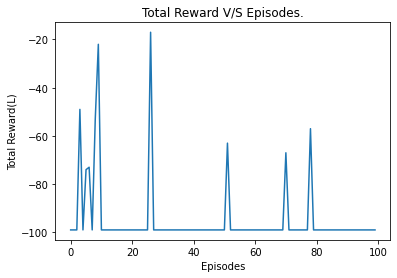

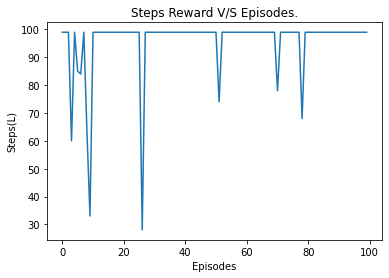

 14%|█▍        | 14/100 [00:11<01:17,  1.11it/s]

running reward: -68.00 at episode (2, 2), frame count 1000


 24%|██▍       | 24/100 [00:33<02:37,  2.07s/it]

running reward: -77.75 at episode (3, 4), frame count 2000


 34%|███▍      | 34/100 [00:56<02:30,  2.28s/it]

running reward: -84.00 at episode (4, 4), frame count 3000


 45%|████▌     | 45/100 [01:19<02:02,  2.23s/it]

running reward: -85.76 at episode (5, 3), frame count 4000


 55%|█████▌    | 55/100 [01:42<01:44,  2.33s/it]

running reward: -87.84 at episode (5, 3), frame count 5000


 65%|██████▌   | 65/100 [02:07<01:40,  2.86s/it]

running reward: -89.55 at episode (5, 5), frame count 6000


 75%|███████▌  | 75/100 [02:30<00:57,  2.31s/it]

running reward: -90.81 at episode (3, 2), frame count 7000


 85%|████████▌ | 85/100 [02:53<00:34,  2.28s/it]

running reward: -91.61 at episode (3, 5), frame count 8000


 96%|█████████▌| 96/100 [03:18<00:08,  2.24s/it]

running reward: -92.19 at episode (4, 2), frame count 9000


100%|██████████| 100/100 [03:26<00:00,  2.06s/it]


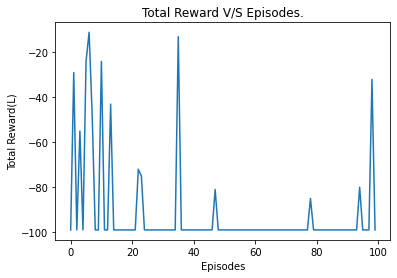

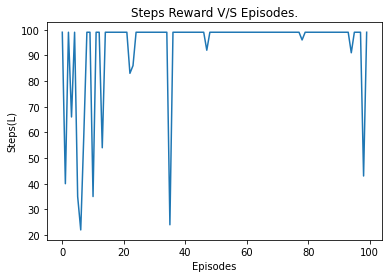

 11%|█         | 11/100 [00:10<01:29,  1.00s/it]

running reward: -78.36 at episode (4, 2), frame count 1000


 26%|██▌       | 26/100 [00:33<02:13,  1.80s/it]

running reward: -68.85 at episode (3, 2), frame count 2000


 43%|████▎     | 43/100 [00:56<01:11,  1.25s/it]

running reward: -61.40 at episode (2, 2), frame count 3000


 61%|██████    | 61/100 [01:20<00:32,  1.19it/s]

running reward: -57.62 at episode (4, 2), frame count 4000


 84%|████████▍ | 84/100 [01:42<00:18,  1.17s/it]

running reward: -50.65 at episode (4, 2), frame count 5000


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


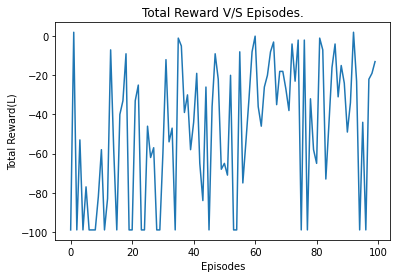

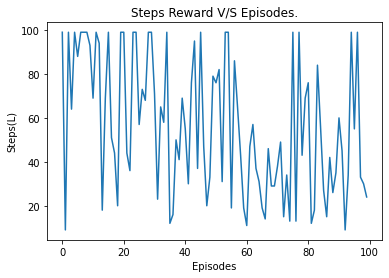

In [16]:
model=0
model_target=0

for no,nv in enumerate(noviceArr):
  global model, model_target
  num_actions=5
  noOfUpdates=1000 #after 10000 frames do a full
  frameForPrediction=4

  action_history = []
  state_history = []
  state_next_history = []
  rewards_history = []
  reward_plot = []
  episode_steps_plot = []
  done_history = []

  model=nv
  model_target=nv
  loss_function = keras.losses.MeanSquaredError()
  optimizer=tf.keras.optimizers.RMSprop()

  def saveCheckPoints():
    plotProgress(reward_plot,'Episodes',f'Total Reward{no}','Total Reward V/S Episodes.')
    print()
    plotProgress(episode_steps_plot,'Episodes',f'Steps{no}','Steps Reward V/S Episodes.')

  #trainAgentInEnv(env3)
  saveCheckPoints()